In [ ]:
import tensorflow as tf
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np


In [ ]:
from google.colab import files
from google.colab import drive

df = pd.read_csv('/content/Target_Ts.csv')
df

,item,org,date,quantity
0,3959294,1617388,2014-03-01,6375
1,3959294,1619228,2014-03-02,2932
2,3959294,40022636,2014-03-03,2641
3,3959294,42023714,2014-03-04,8910
4,3959313,1617388,2014-03-05,1815
...,...,...,...,...
9486,140535880,42023714,2021-02-01,1271
9487,149440644,1617388,2021-02-01,1816
9488,149440644,1619228,2021-02-01,1185
9489,149440644,40022636,2021-02-01,499


In [ ]:
target_col = df['quantity']
target_col
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].map(pd.Timestamp.timestamp)
df['date'].dtype

#pd.to_datetime(['date']).astype(int) / 10**9


<ipython-input-127-6ac680bc9023>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)


dtype('float64')

In [ ]:
df

,item,org,date,quantity
0,3959294,1617388,1.393632e+09,6375
1,3959294,1619228,1.393718e+09,2932
2,3959294,40022636,1.393805e+09,2641
3,3959294,42023714,1.393891e+09,8910
4,3959313,1617388,1.393978e+09,1815
...,...,...,...,...
9486,140535880,42023714,1.612138e+09,1271
9487,149440644,1617388,1.612138e+09,1816
9488,149440644,1619228,1.612138e+09,1185
9489,149440644,40022636,1.612138e+09,499


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

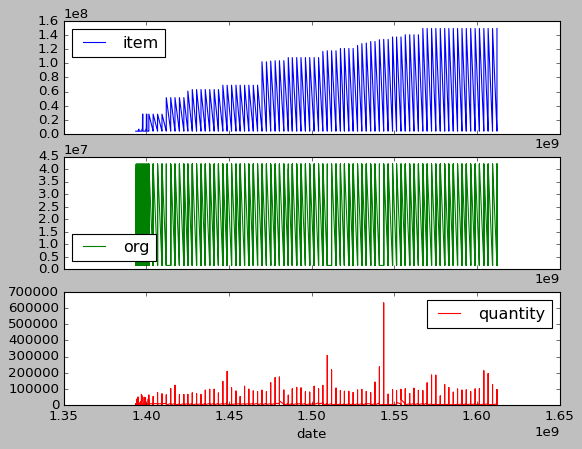

In [ ]:
df.set_index('date')[['item','org','quantity']].plot(subplots=True)

In [ ]:
from sklearn.preprocessing import minmax_scale
df

,item,org,date,quantity
0,3959294,1617388,1.393632e+09,6375
1,3959294,1619228,1.393718e+09,2932
2,3959294,40022636,1.393805e+09,2641
3,3959294,42023714,1.393891e+09,8910
4,3959313,1617388,1.393978e+09,1815
...,...,...,...,...
9486,140535880,42023714,1.612138e+09,1271
9487,149440644,1617388,1.612138e+09,1816
9488,149440644,1619228,1.612138e+09,1185
9489,149440644,40022636,1.612138e+09,499


In [ ]:
df_input=df[['date','quantity']]
# multivariate input
df_input

,date,quantity
0,1.393632e+09,6375
1,1.393718e+09,2932
2,1.393805e+09,2641
3,1.393891e+09,8910
4,1.393978e+09,1815
...,...,...
9486,1.612138e+09,1271
9487,1.612138e+09,1816
9488,1.612138e+09,1185
9489,1.612138e+09,499


In [ ]:
#Scaling the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_input)
scaled_data

array([[0.00000000e+00, 1.00772670e-02],
       [3.95413207e-04, 4.63475242e-03],
       [7.90826414e-04, 4.17475483e-03],
       ...,
       [1.00000000e+00, 1.87318609e-03],
       [1.00000000e+00, 7.88793131e-04],
       [1.00000000e+00, 1.53016383e-03]])

In [ ]:
def df_to_X_y(df, window_size):
  df_as_np = np.array(df)
  X=[]
  y=[]
  for i in range(len(df_as_np)-window_size):
    row=[r for r in df_as_np[i:i+window_size]] # includes rows fron i to i + windows_size - 1
    X.append(row)
    label=df_as_np[i+window_size][1]    # includes only the quantity column starting from the window_size'th row
    y.append(label)

  return np.array(X), np.array(y)


In [ ]:
# window size = 10
X_final, y_final = df_to_X_y(scaled_data, 10)
X_final.shape, y_final.shape

((9481, 10, 2), (9481,))

In [ ]:
scaled_data[7584:,0]

array([0.89086595, 0.89086595, 0.89086595, ..., 1.        , 1.        ,
       1.        ])

In [ ]:
# Split the data into train (60 %), valid (20 %) and test (20 %)
X_train, y_train = X_final[:5688], y_final[:5688]
X_valid, y_valid = X_final[5688:7584], y_final[5688:7584]
X_test, y_test = X_final[7584:], y_final[7584:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((5688, 10, 2), (5688,), (1896, 10, 2), (1896,), (1897, 10, 2), (1897,))

In [ ]:
win_length=10

batch_size=64
num_features=2

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape= (win_length,num_features), return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.LSTM(64,activation="tanh",input_shape= (win_length,num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))

#model.add(tf.keras.layers.LSTM(16, return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))



In [ ]:
 model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 128)           67072     
                                                                 
 lstm_10 (LSTM)              (None, 10, 64)            49408     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 10, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 149569 (584.25 KB)
Trainable params: 149

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')
model.compile( loss = tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.00001), metrics = [tf.metrics.MeanAbsoluteError()])

history= model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), shuffle =False, callbacks = [early_stopping])

Epoch 1/50
178/178 [==============================] - 15s 52ms/step - loss: 0.0011 - mean_absolute_error: 0.0147 - val_loss: 5.5127e-04 - val_mean_absolute_error: 0.0099
Epoch 2/50
178/178 [==============================] - 6s 32ms/step - loss: 0.0011 - mean_absolute_error: 0.0145 - val_loss: 5.4798e-04 - val_mean_absolute_error: 0.0094
Epoch 3/50
178/178 [==============================] - 7s 40ms/step - loss: 0.0011 - mean_absolute_error: 0.0143 - val_loss: 5.4589e-04 - val_mean_absolute_error: 0.0093
Epoch 4/50
178/178 [==============================] - 6s 32ms/step - loss: 0.0011 - mean_absolute_error: 0.0141 - val_loss: 5.4435e-04 - val_mean_absolute_error: 0.0090
Epoch 5/50
178/178 [==============================] - 7s 41ms/step - loss: 0.0011 - mean_absolute_error: 0.0142 - val_loss: 5.4272e-04 - val_mean_absolute_error: 0.0089
Epoch 6/50
178/178 [==============================] - 6s 32ms/step - loss: 0.0011 - mean_absolute_error: 0.0142 - val_loss: 5.4138e-04 - val_mean_absolute

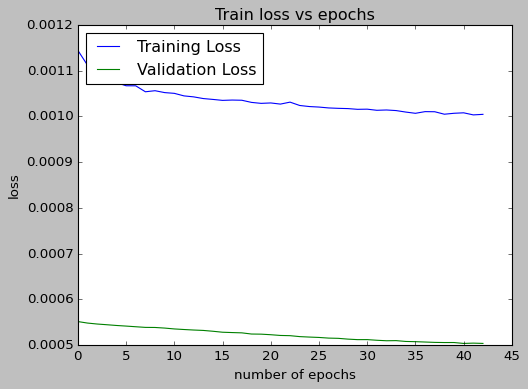

In [ ]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']
rnn=len(val_loss)
rn=range(rnn)
train_loss

plt.figure(1,figsize=(7,5))
plt.plot(rn, train_loss)
plt.plot(rn, val_loss)
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('Train loss vs epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.style.use(['classic'])


In [ ]:
predictions = model.predict(X_test)

60/60 [==============================] - 2s 10ms/step


In [ ]:
len(predictions)

1897

In [ ]:
predictions

array([[0.00381322],
       [0.00382076],
       [0.00387688],
       ...,
       [0.00337767],
       [0.00328175],
       [0.0029926 ]], dtype=float32)

In [ ]:
y_test

array([0.00090577, 0.0057476 , 0.00232528, ..., 0.00187319, 0.00078879,
       0.00153016])

In [ ]:
len(predictions), len(y_test)

(1897, 1897)

In [ ]:
predictions.flatten().shape

(1897,)

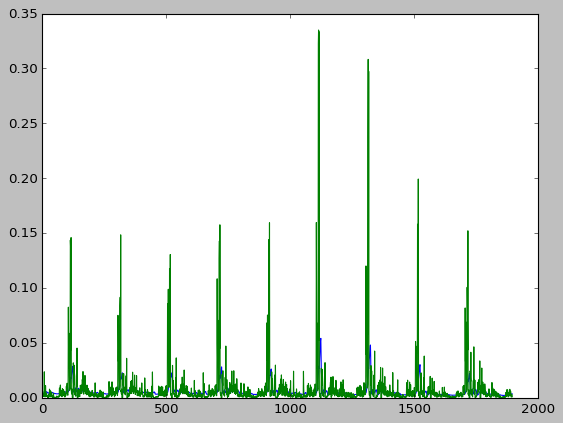

In [ ]:
df1=pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
plt.plot(df1['Predictions'][0:len(predictions)-1])
plt.plot(df1['Actuals'][0:len(predictions)-1])

In [ ]:
df_pred=pd.concat([ pd.DataFrame(scaled_data[7584:9481,0]),pd.DataFrame(predictions)], axis=1)

In [ ]:
rev_trans = scaler.inverse_transform(df_pred)

In [ ]:
rev_trans

array([[1.58829120e+09, 2.41229032e+03],
       [1.58829120e+09, 2.41706109e+03],
       [1.58829120e+09, 2.45256187e+03],
       ...,
       [1.61213760e+09, 2.13675602e+03],
       [1.61213760e+09, 2.07607754e+03],
       [1.61213760e+09, 1.89315244e+03]])

In [ ]:
df_final = df_input [predictions.shape[0]*-1:]

In [ ]:
df_final

,date,quantity
7594,1.588291e+09,573
7595,1.588291e+09,3636
7596,1.588291e+09,1471
7597,1.588291e+09,596
7598,1.588291e+09,1884
...,...,...
9486,1.612138e+09,1271
9487,1.612138e+09,1816
9488,1.612138e+09,1185
9489,1.612138e+09,499


In [ ]:
df_final.count()

date        1897
quantity    1897
dtype: int64

In [ ]:
df_final['quantity_pred']=rev_trans[:,1:]

In [ ]:
df_final

,date,quantity,quantity_pred
7594,1.588291e+09,573,2412.290322
7595,1.588291e+09,3636,2417.061093
7596,1.588291e+09,1471,2452.561870
7597,1.588291e+09,596,2492.902054
7598,1.588291e+09,1884,2447.984935
...,...,...,...
9486,1.612138e+09,1271,2079.375686
9487,1.612138e+09,1816,2095.702944
9488,1.612138e+09,1185,2136.756019
9489,1.612138e+09,499,2076.077535


<Axes: >

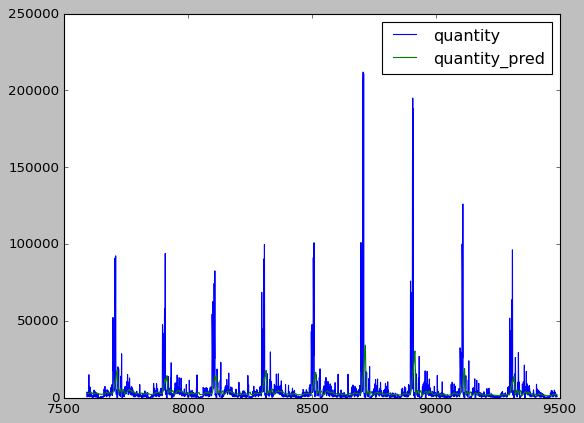

In [ ]:
df_final[['quantity','quantity_pred']].plot()

In [ ]:
df_final['quantity_pred']= df_final['quantity_pred'].astype(int)


In [ ]:
df_part = df.iloc[7594:9491,0]

In [ ]:
len(df_part), len(df_final)

(1897, 1897)

In [ ]:
df_part

7594    116549229
7595    116549238
7596    116549238
7597    116549238
7598    116549238
          ...    
9486    140535880
9487    149440644
9488    149440644
9489    149440644
9490    149440644
Name: item, Length: 1897, dtype: int64

In [ ]:
df_final

,date,quantity,quantity_pred
7594,1.588291e+09,573,2412
7595,1.588291e+09,3636,2417
7596,1.588291e+09,1471,2452
7597,1.588291e+09,596,2492
7598,1.588291e+09,1884,2447
...,...,...,...
9486,1.612138e+09,1271,2079
9487,1.612138e+09,1816,2095
9488,1.612138e+09,1185,2136
9489,1.612138e+09,499,2076


In [ ]:
df_concat = pd.concat([df_part, df_final], axis=1)
df_concat

,item,date,quantity,quantity_pred
7594,116549229,1.588291e+09,573,2412
7595,116549238,1.588291e+09,3636,2417
7596,116549238,1.588291e+09,1471,2452
7597,116549238,1.588291e+09,596,2492
7598,116549238,1.588291e+09,1884,2447
...,...,...,...,...
9486,140535880,1.612138e+09,1271,2079
9487,149440644,1.612138e+09,1816,2095
9488,149440644,1.612138e+09,1185,2136
9489,149440644,1.612138e+09,499,2076


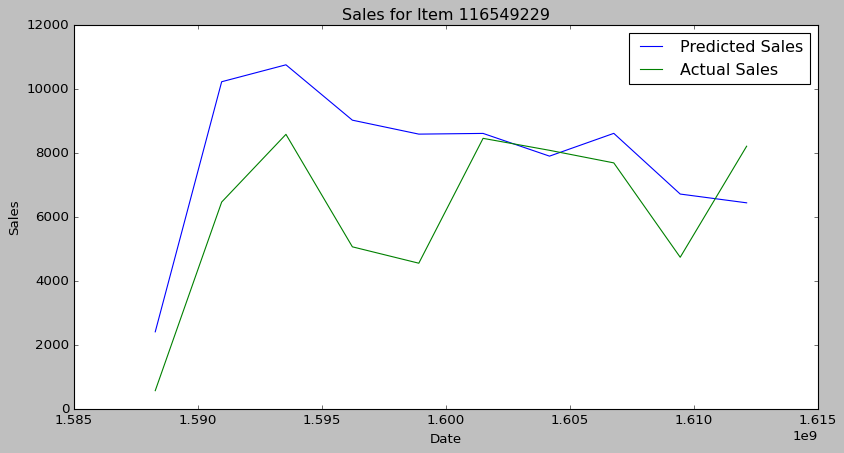

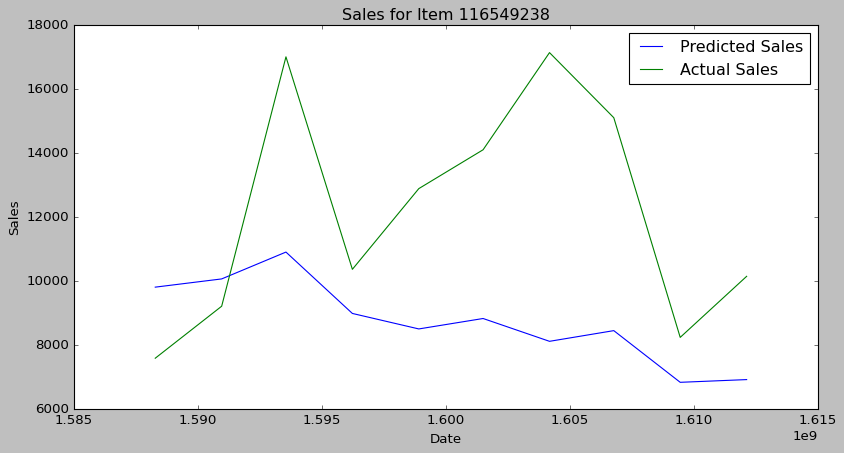

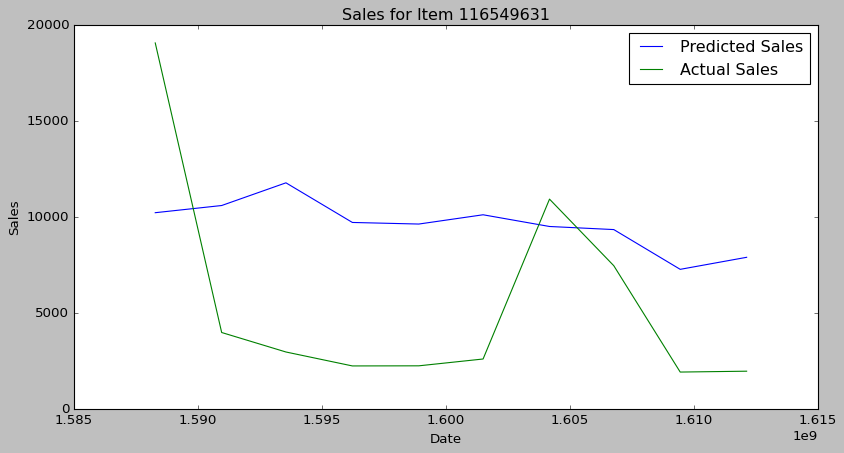

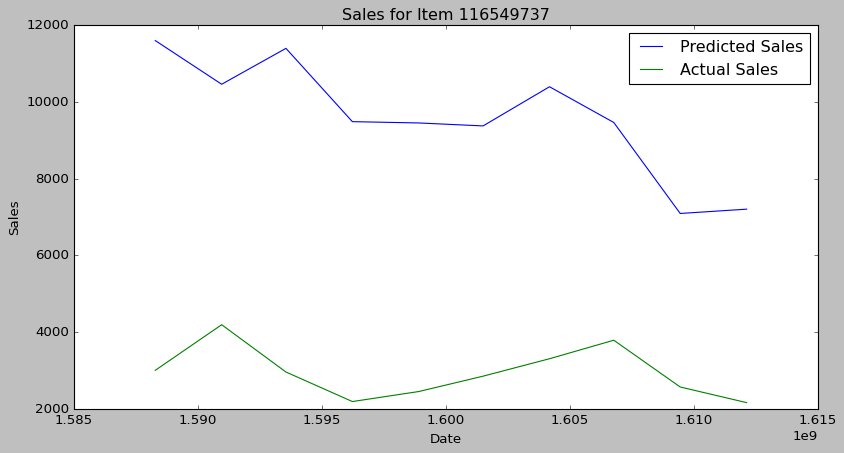

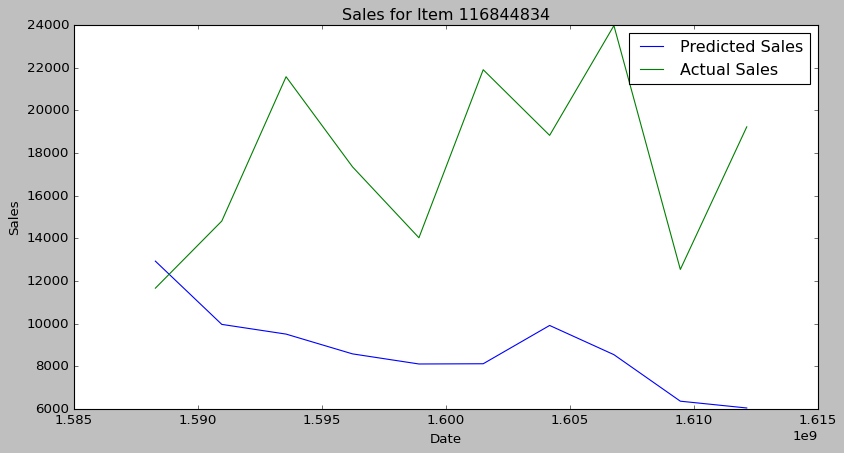

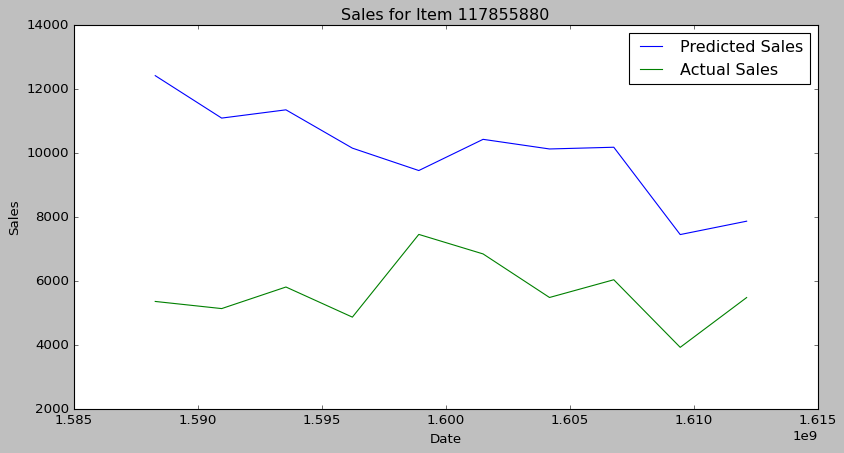

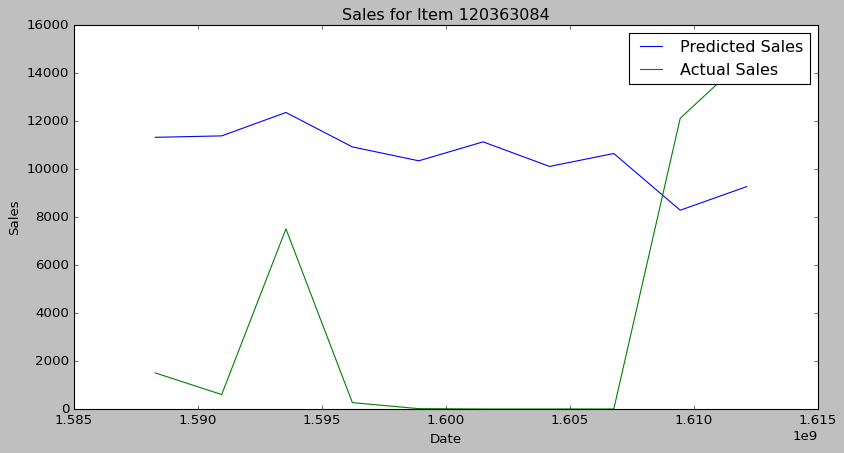

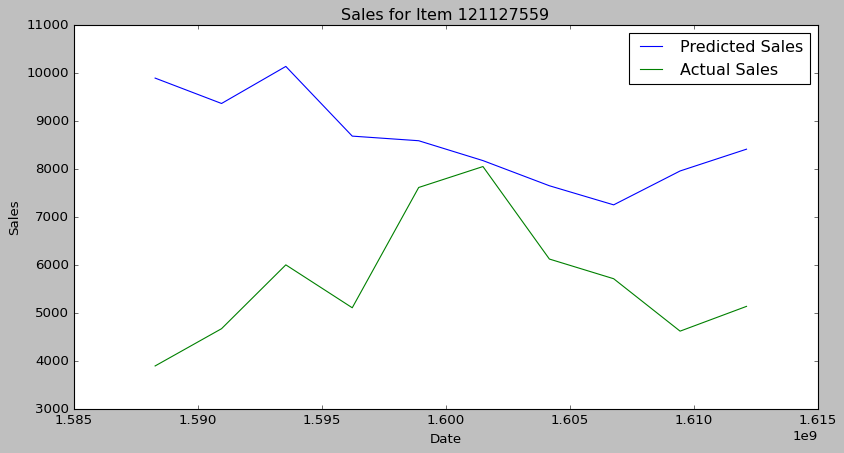

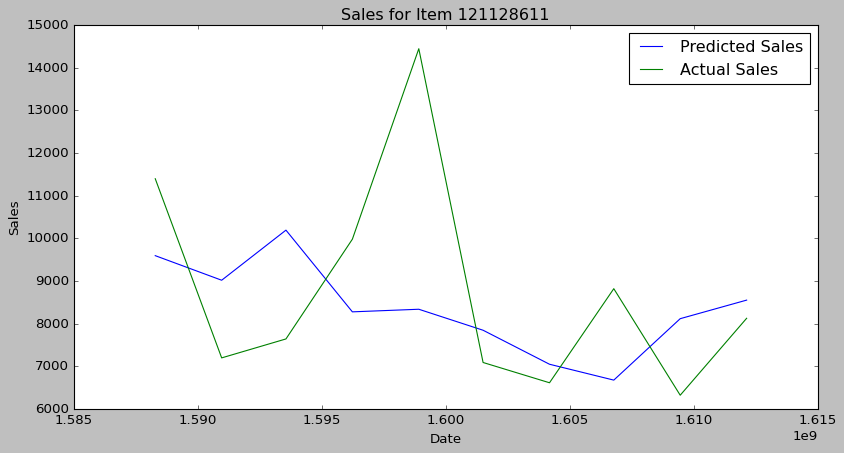

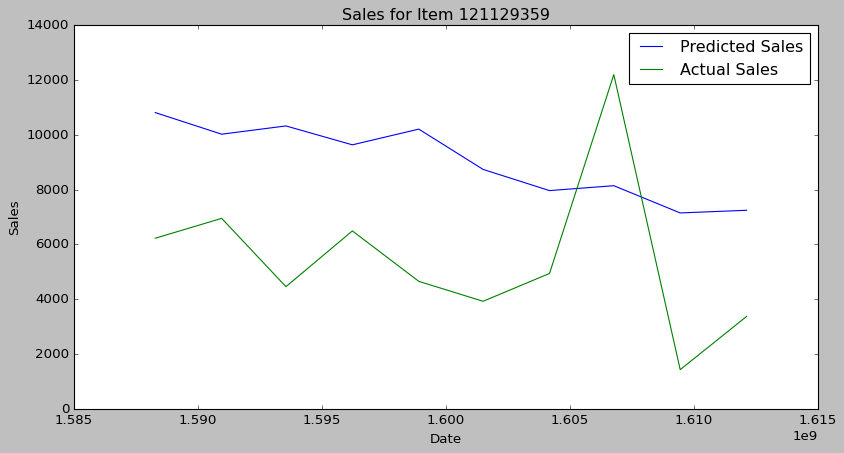

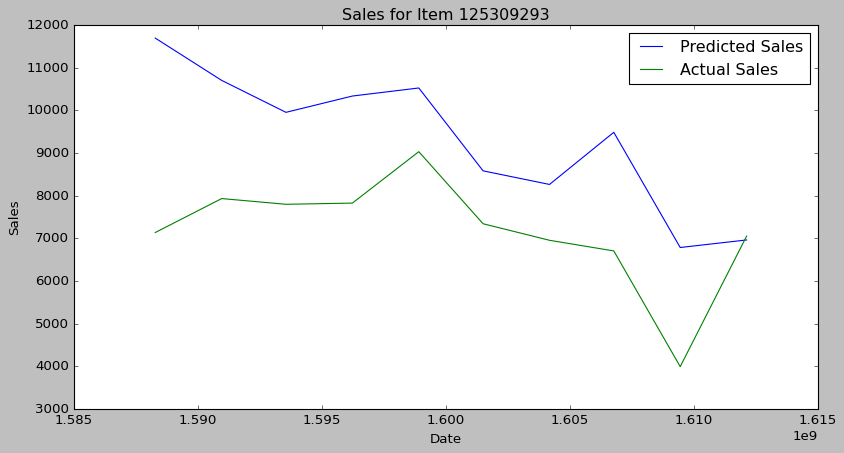

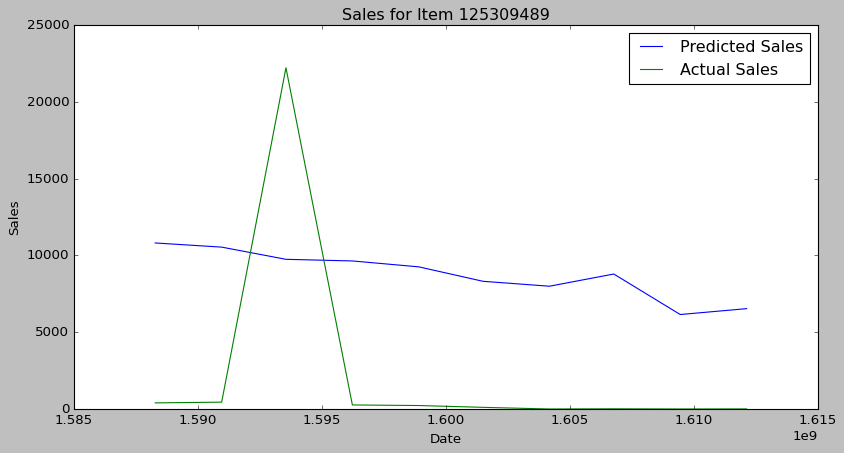

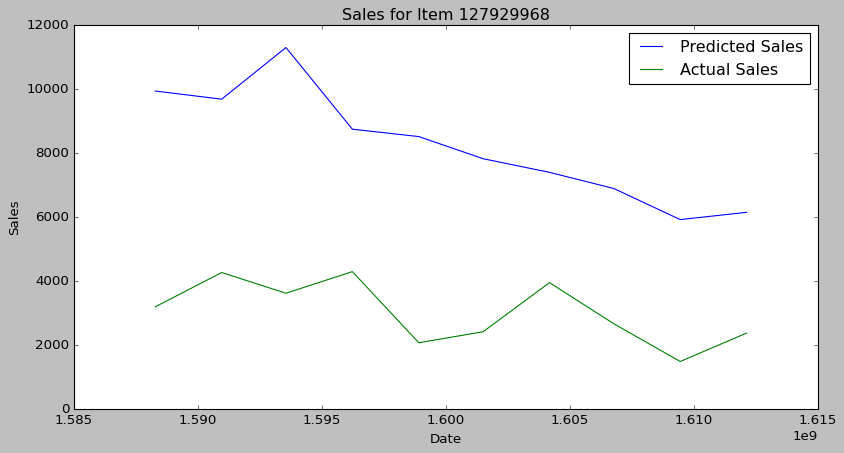

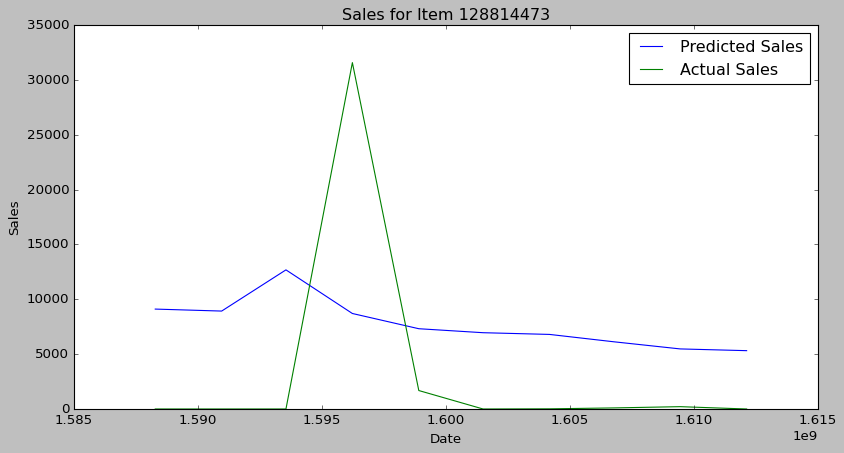

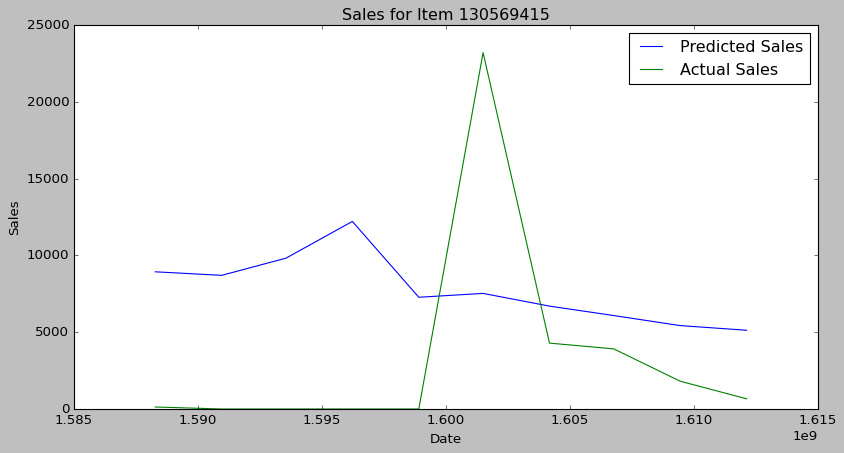

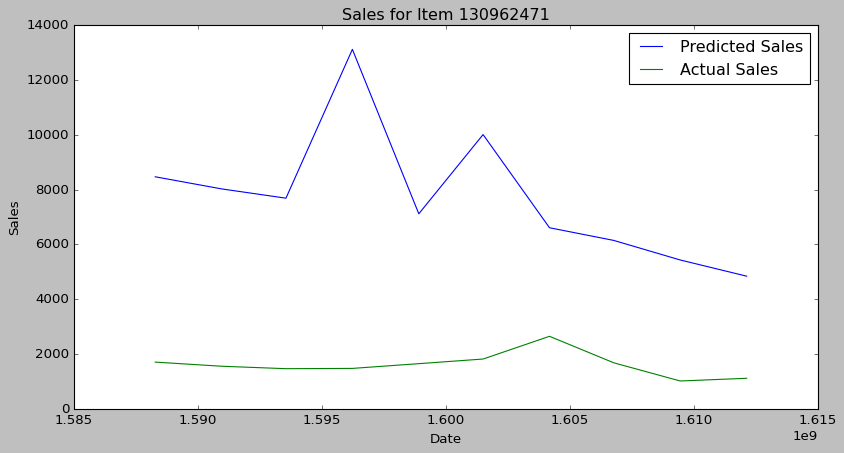

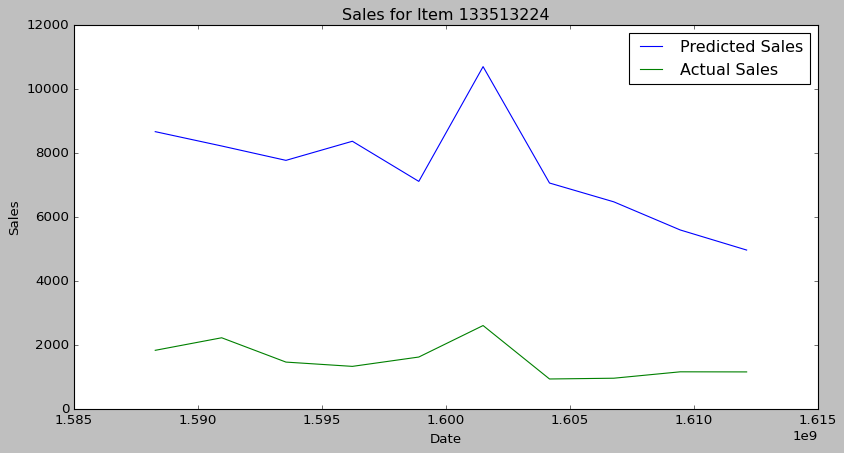

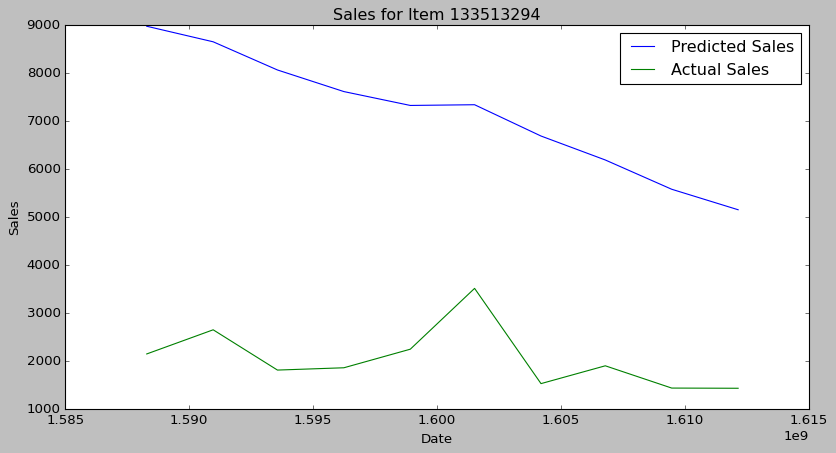

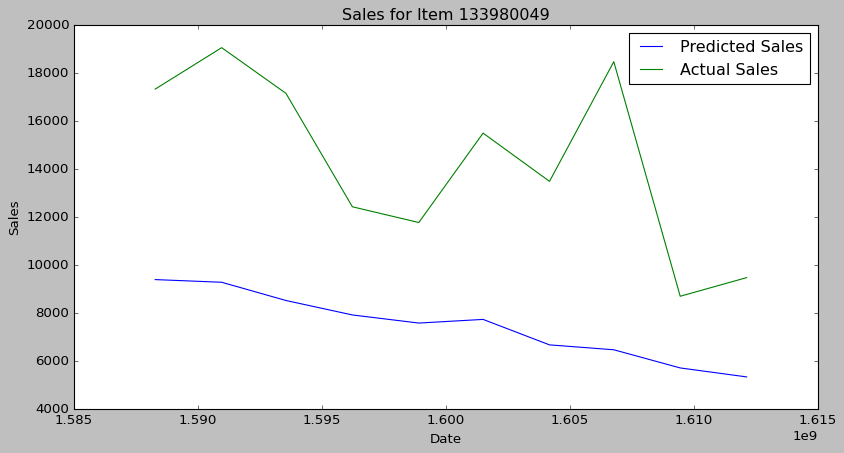

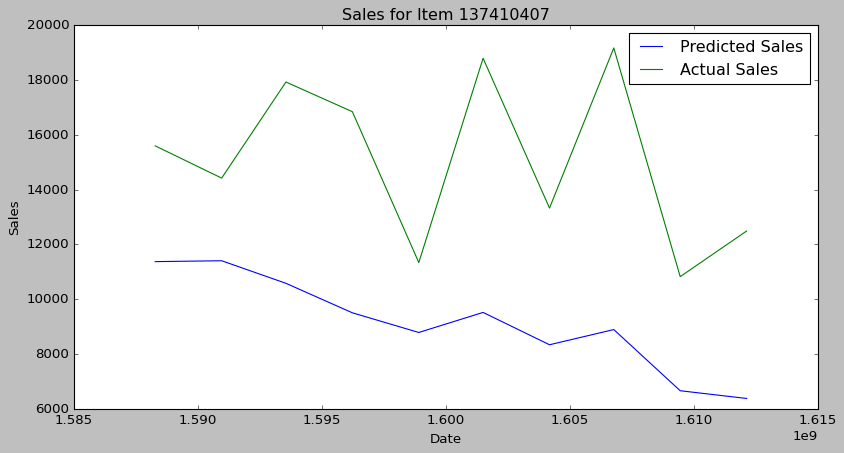

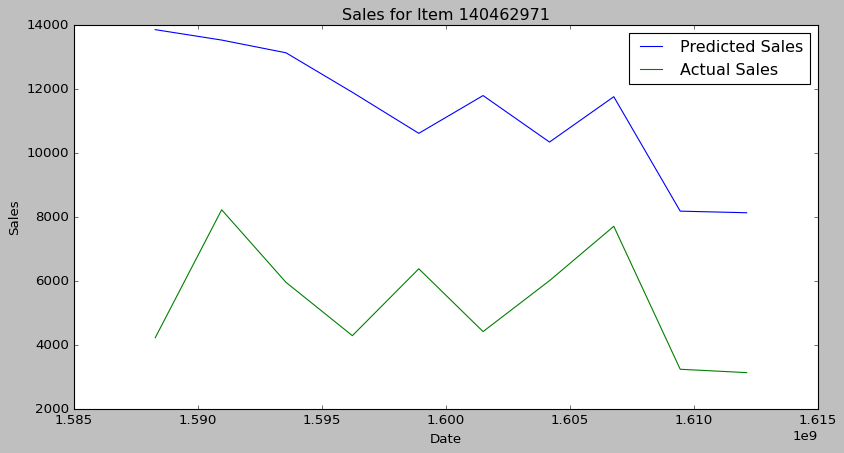

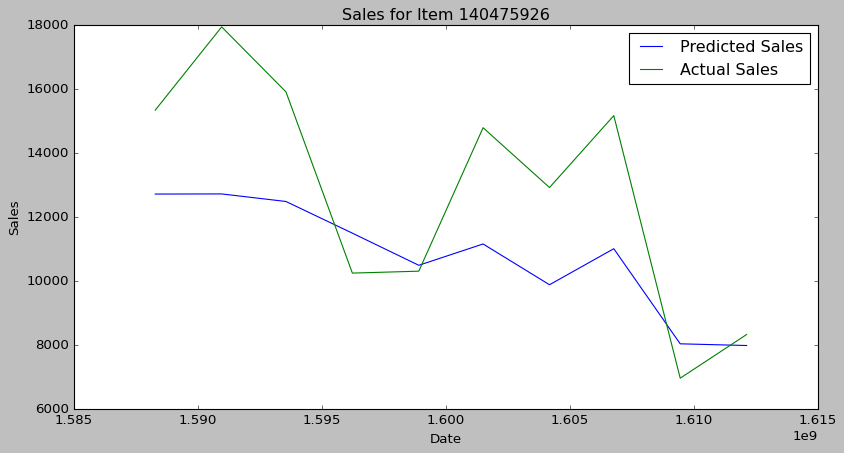

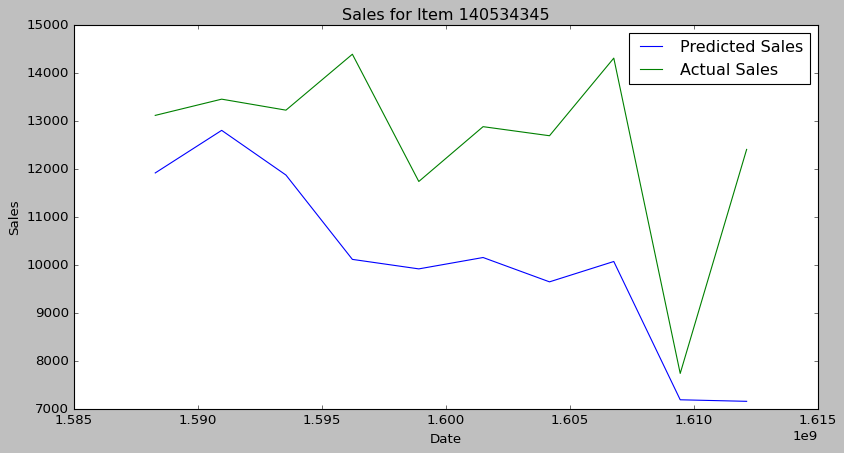

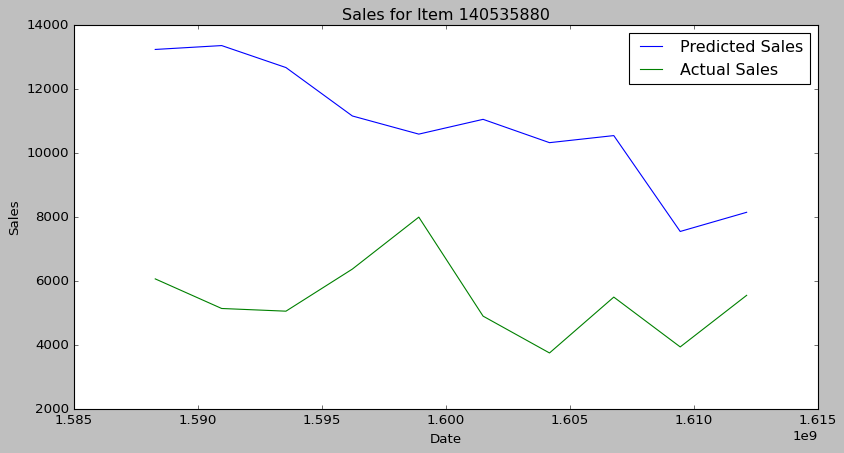

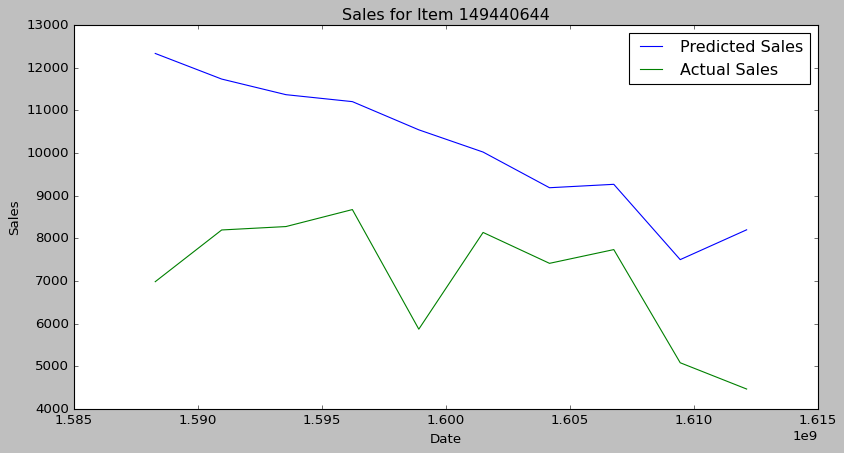

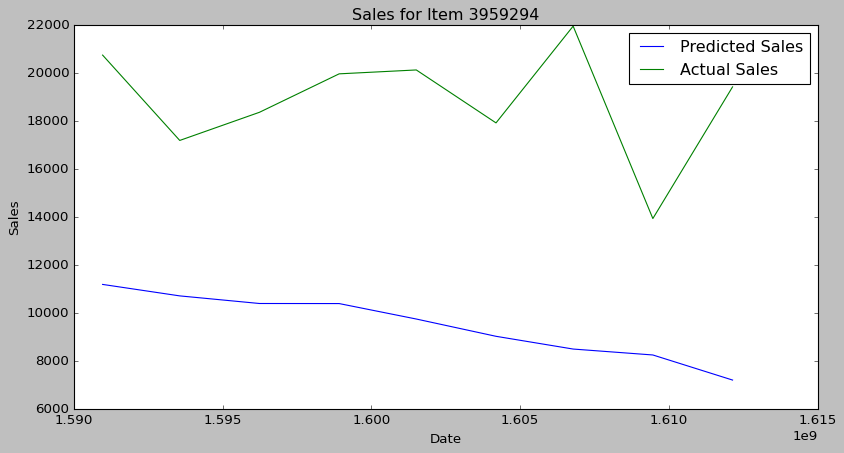

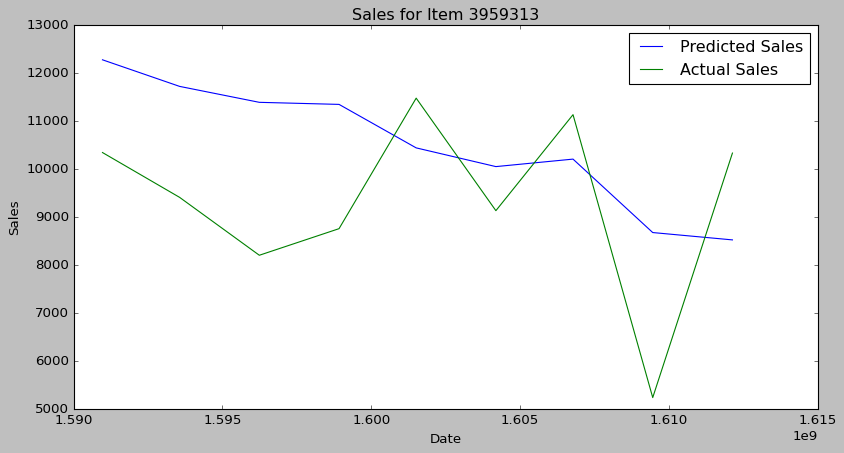

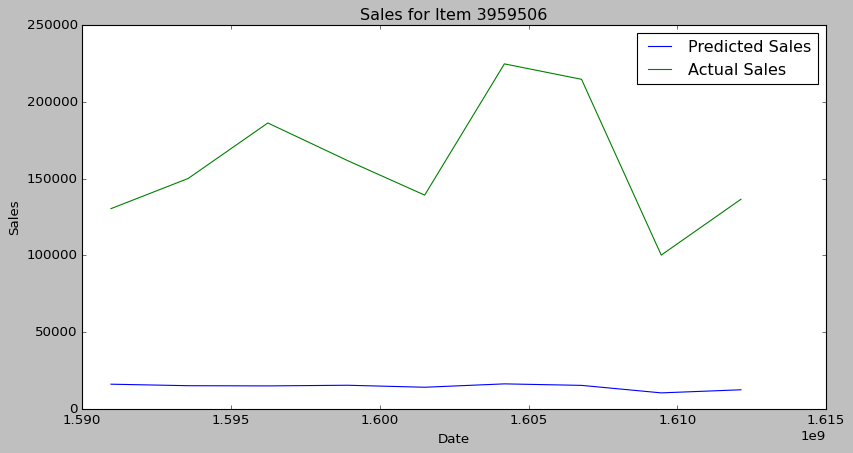

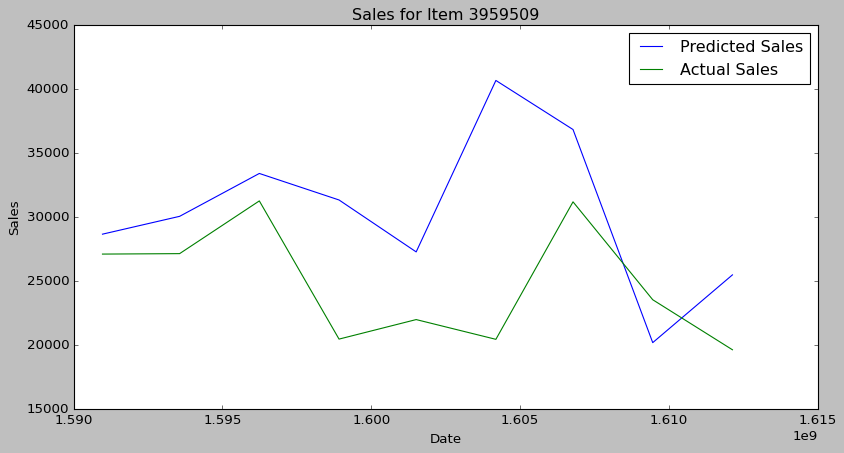

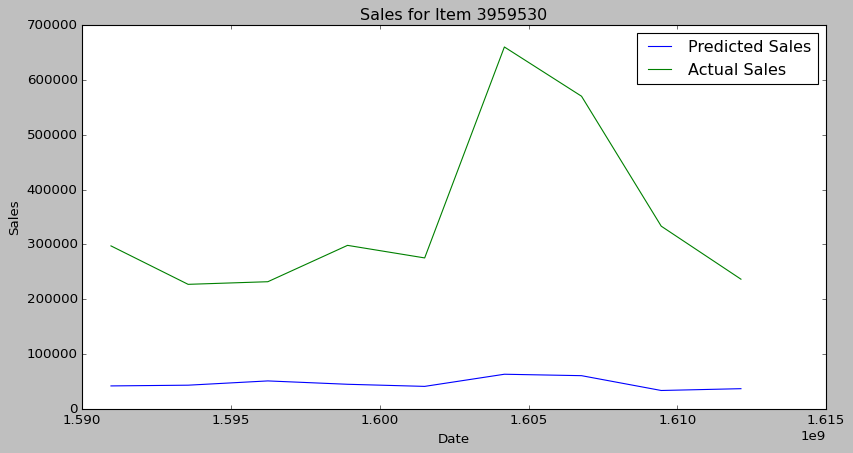

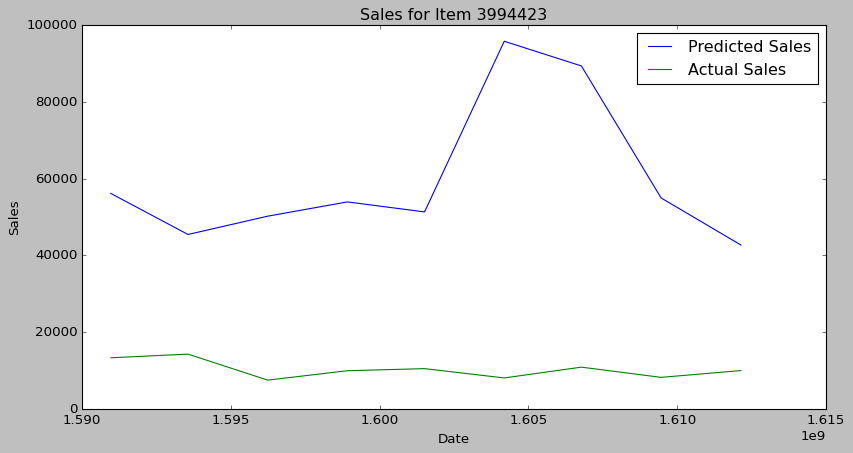

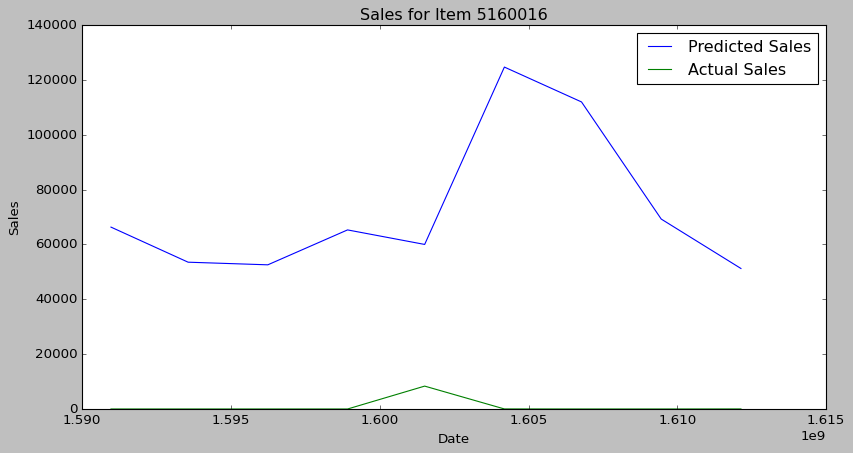

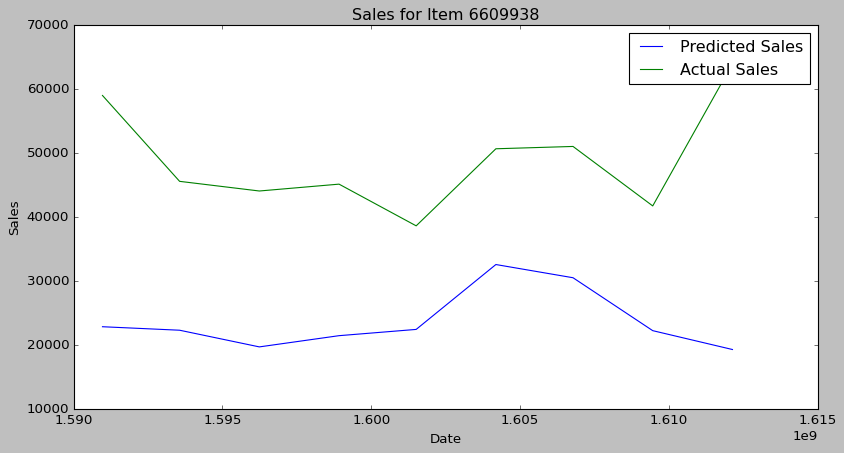

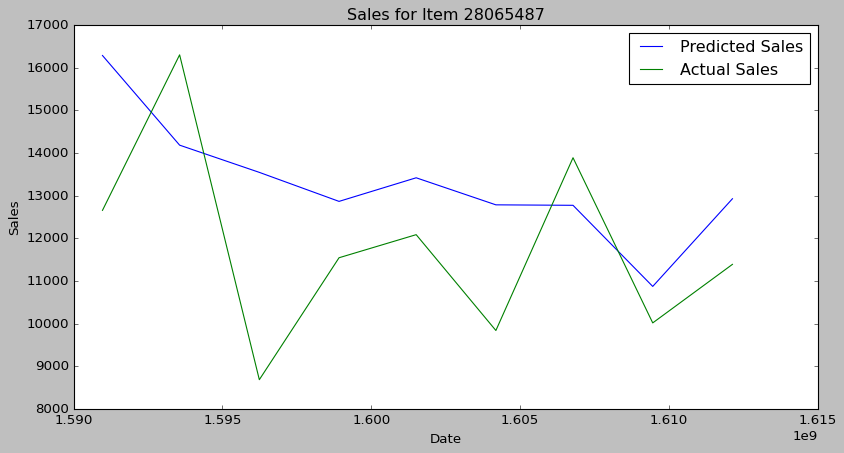

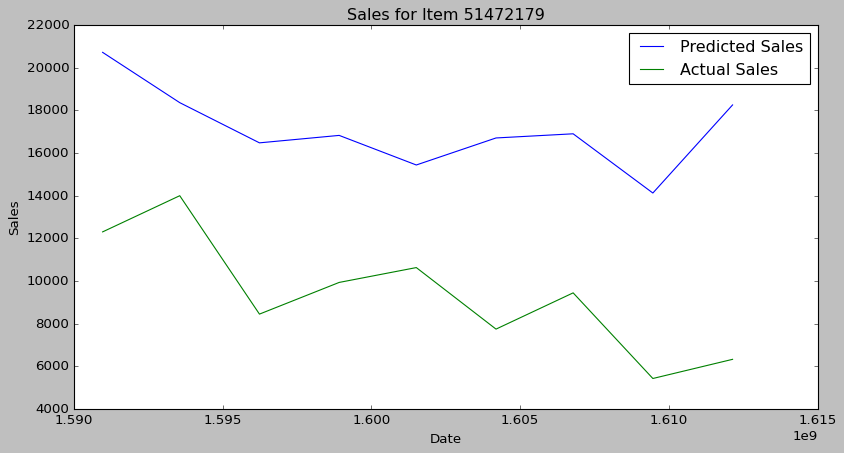

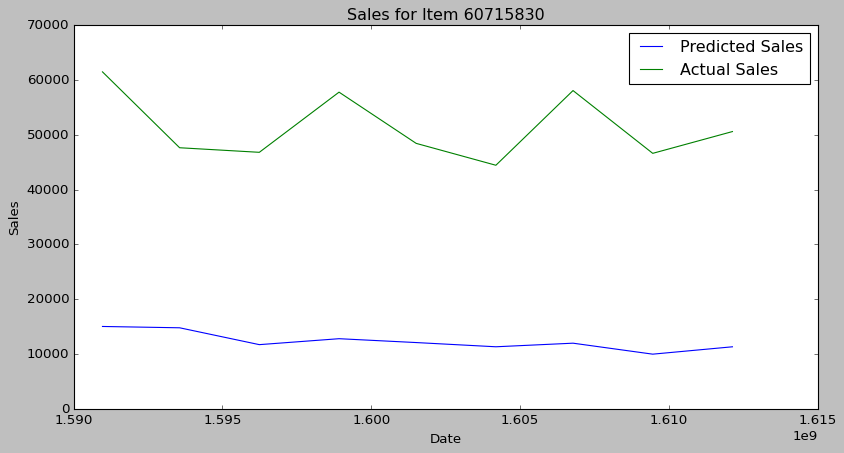

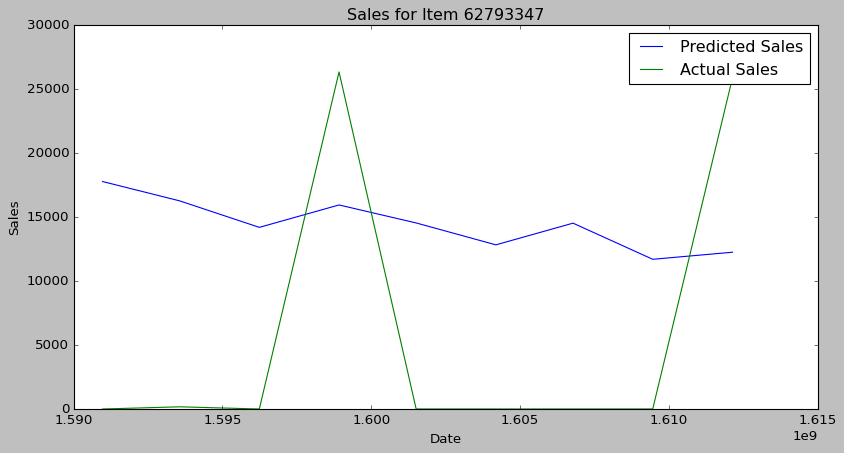

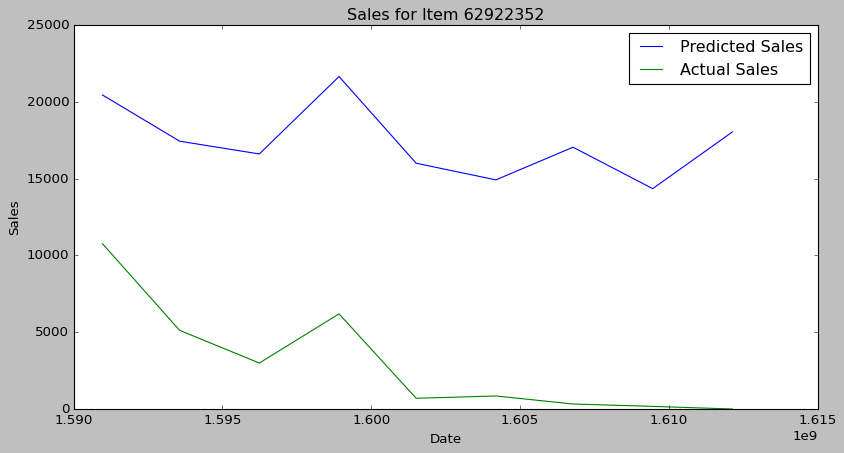

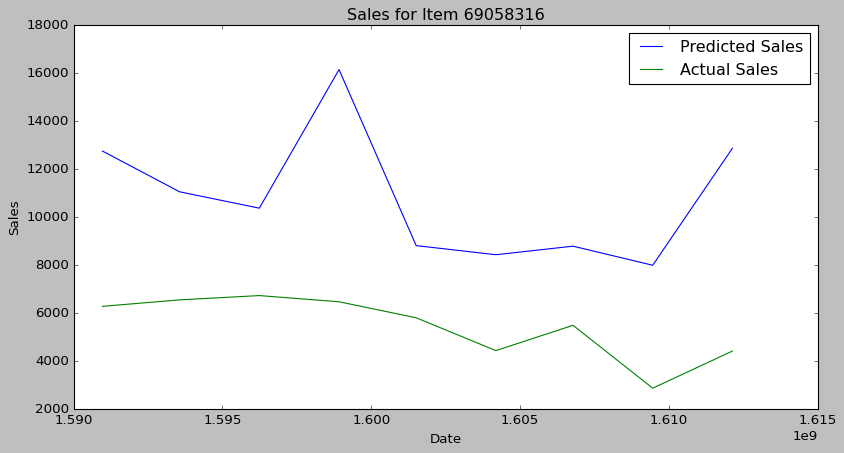

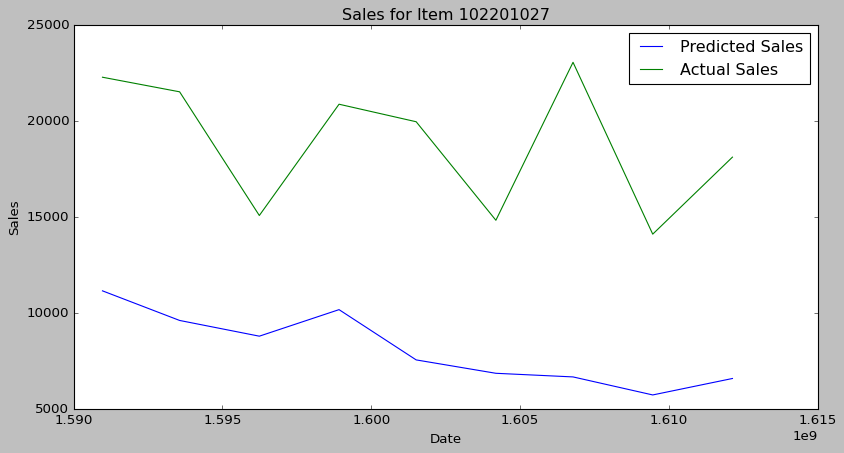

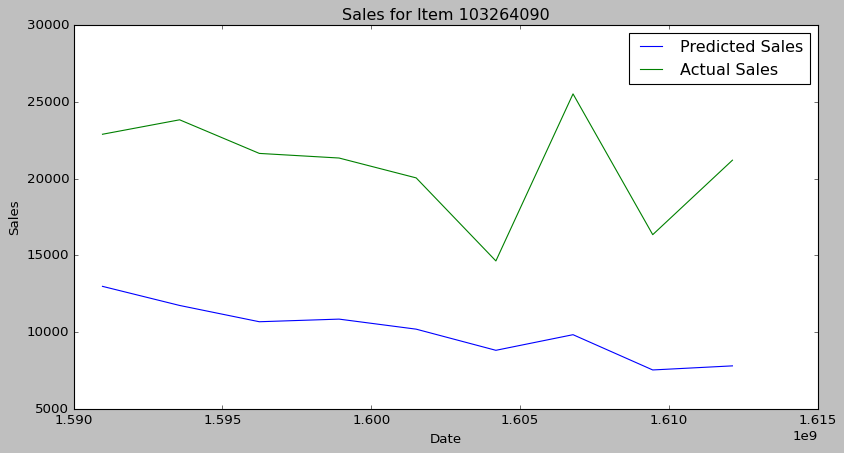

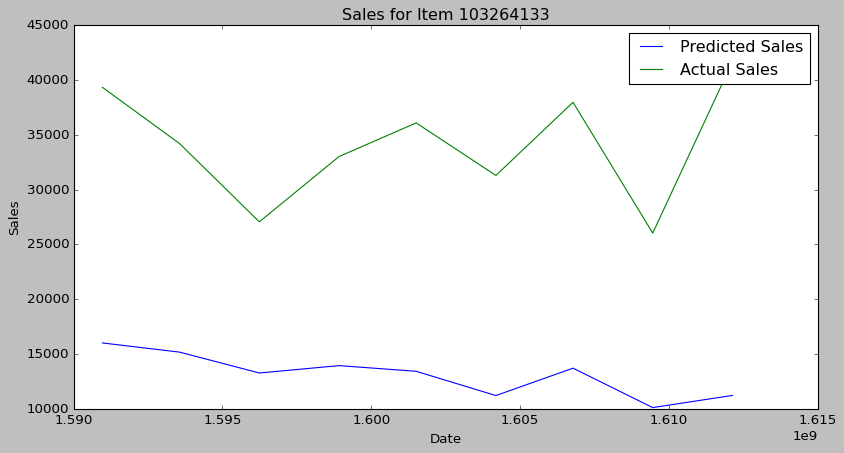

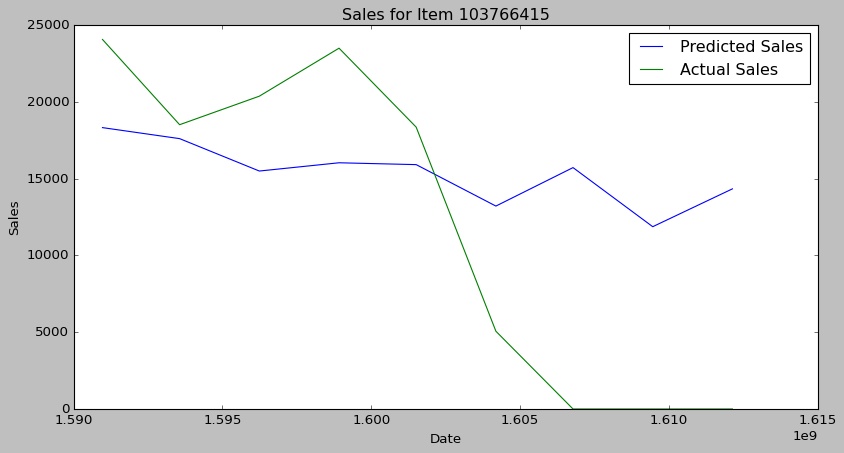

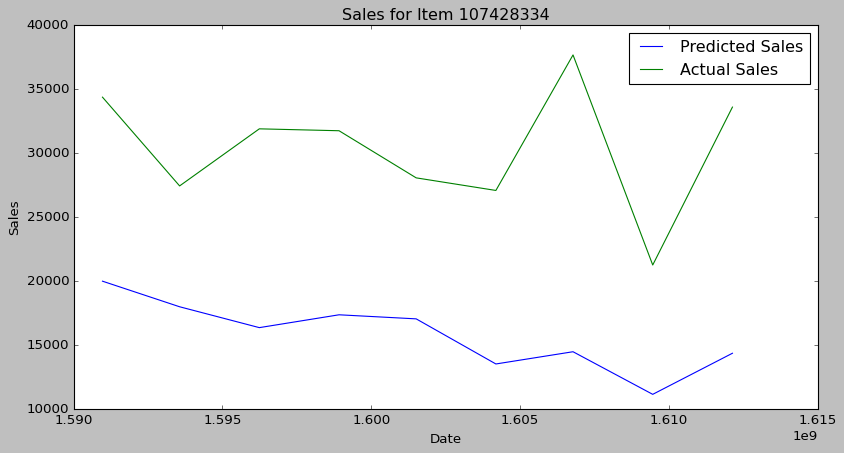

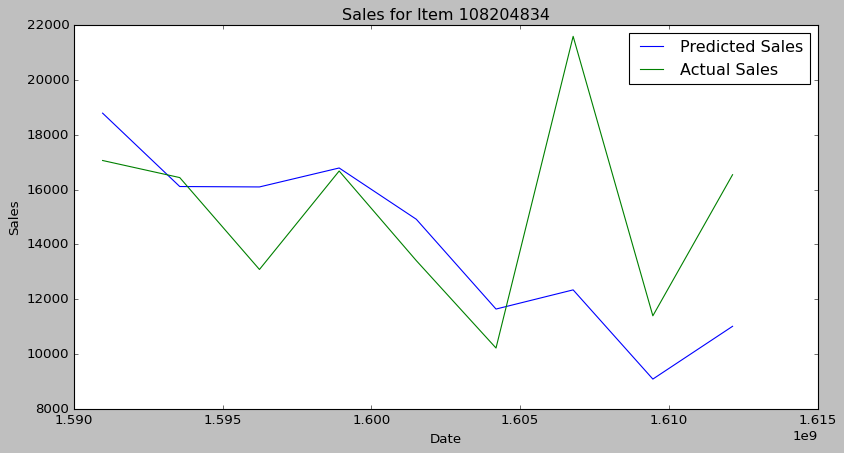

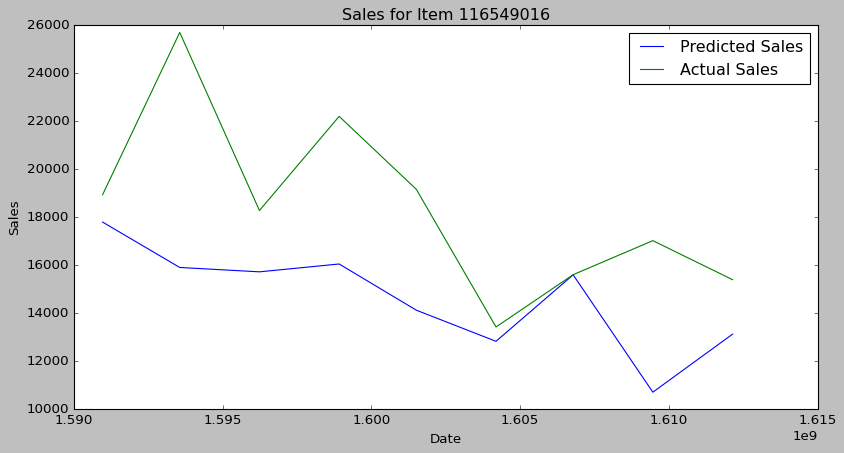

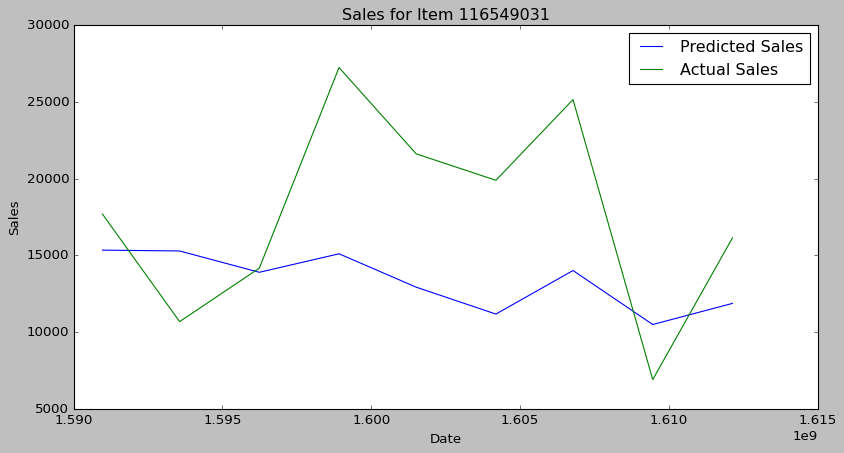

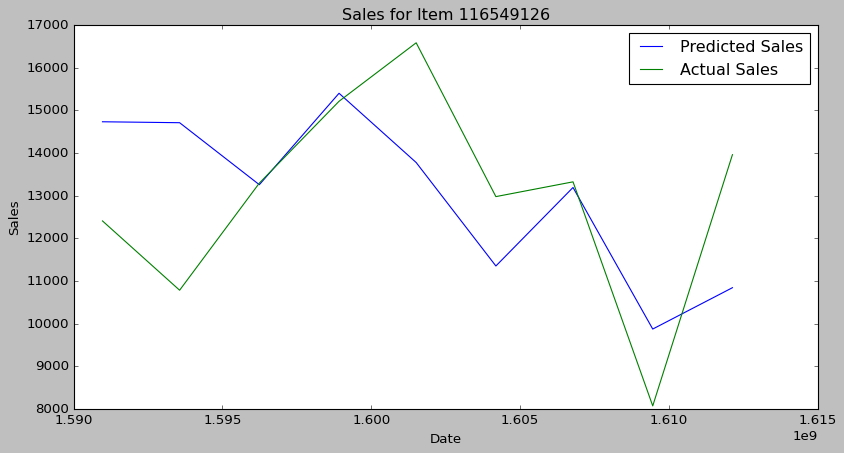

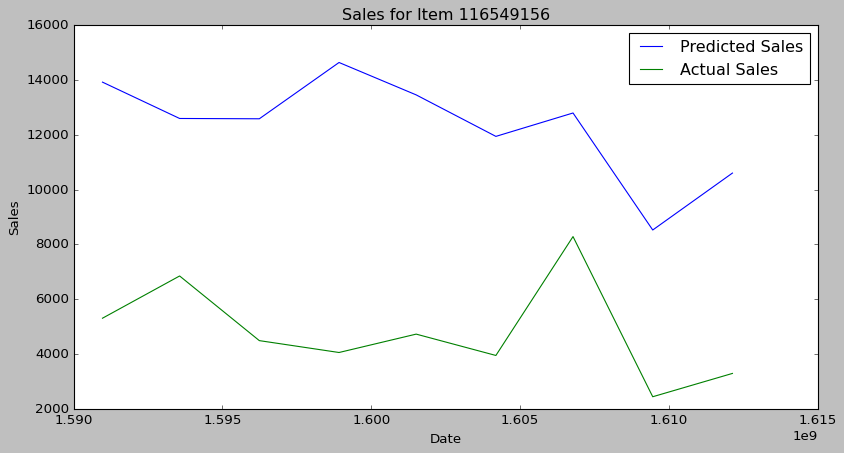

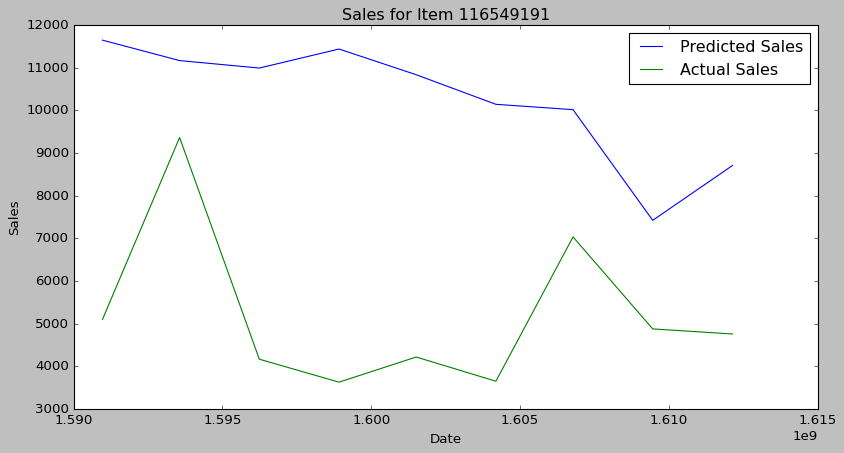

In [ ]:
import matplotlib.pyplot as plt


predicted_sales = df_concat['quantity_pred']
# Combine predicted sales with original dataframe
#df_final['predicted_sales'] = predicted_sales

# Aggregate predicted and actual sales by date and item
total_sales_by_date = df_concat.groupby(['date', 'item']).agg({'quantity_pred': 'sum', 'quantity': 'sum'}).reset_index()

# Plot total sales for each item
for item in total_sales_by_date['item'].unique():
    item_data = total_sales_by_date[total_sales_by_date['item'] == item]
    item_data_sorted = item_data.sort_values(by='date')  # Sort by date

    plt.figure(figsize=(12, 6))

    plt.plot(item_data_sorted['date'], item_data_sorted['quantity_pred'], label='Predicted Sales')
    plt.plot(item_data_sorted['date'], item_data_sorted['quantity'], label='Actual Sales')

    plt.title(f'Sales for Item {item}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [ ]:
# Calculate mse and mae
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(df_final['quantity_pred'], df_final['quantity'])

mse = mean_squared_error(df_final['quantity_pred'], df_final['quantity'])
mae, mse

(4771.153927253558, 217998354.31787032)